In [1]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import random
import cmath #complex numbers
from numpy import linalg
from scipy.integrate import solve_ivp

In [43]:
## REACTION KINETICS ##
a = 35
b = 16
c = 9
d = 2/5

def mimura_murray(u, v, a = a, b = b, c = c, d = d):
    f = ((a + b * u - u * u) / c - v) * u
    g = (u - (1 + d * v)) * v
    return [f, g]

def compute_fixed_point(a = a, b = b, c = c, d = d):
    coeff = [d*d, (c + 2*d - b * d), (1 - a - b)]
    roots = np.roots(coeff)
    v = max(roots)
    u = 1 + d * v
    return [u,v]

def compute_jacobian(a = a, b = b, c = c, d = d):
    [u, v] = compute_fixed_point()
    f_partial_u = (1 / c) * (2 * b * u - 3 * u * u + a - c * v)
    f_partial_v = - u
    g_partial_u = + v
    g_partial_v = - 2 * d * v + u - 1
    J = np.zeros((2, 2))
    J[0, 0] = f_partial_u
    J[0, 1] = f_partial_v
    J[1, 0] = g_partial_u
    J[1, 1] = g_partial_v
    return J

def compute_critical_sigma():
    J = compute_jacobian()
    sigma = (J[0,0] * J[1,1] - 2 * J[0,1] * J[1, 0] + 2 * np.sqrt(J[0,1] * J[1,0] * (J[0,1] * J[1,0] - J[0,0] * J[1,1]))) / np.square(J[0, 0])
    return sigma

## DIFFUSION  ##
epsilon = 0.12
sigma = 15.6

def compute_critical_eigenvalue(epsilon = epsilon):
    sigma = compute_critical_sigma()
    J = compute_jacobian()
    #num = sigma * (J[0, 0] - J[1, 1]) - (sigma + 1) * np.sqrt(sigma * np.abs(J[1,1]) * J[1, 0])    
    #den = epsilon * sigma * (sigma - 1)
    #eig = num / den
    #return np.abs(eig)
    value = (1 / epsilon) * np.sqrt(np.linalg.det(J) / sigma)
    return value

def compute_upper_branch(Lambda, epsilon = epsilon, sigma = sigma):
    J = compute_jacobian()
    first_term = J[0,0] + J[1,1] - (1 + sigma) * epsilon * Lambda
    second_term = 4 * J[0,1] * J[1,0] + np.square(J[0,0] - J[1,1] - (1 - sigma) * epsilon * Lambda)
    upper_branch = 0.5 * (first_term + cmath.sqrt(second_term))
    return upper_branch.real

def compute_lower_branch(Lambda, epsilon = epsilon, sigma = sigma):
    J = compute_jacobian()
    first_term = J[0,0] + J[1,1] - (1 + sigma) * epsilon * Lambda
    second_term = 4 * J[0,1] * J[1,0] + np.square(J[0,0] - J[1,1] - (1 - sigma) * epsilon * Lambda)
    lower_branch = 0.5 * (first_term - cmath.sqrt(second_term))
    return lower_branch.real


# GRAPH PARAMETERS AND FUNCTIONS #

num_nodes = 200
mean_degree = 10

# define a Barabasi-Albert graph with node indices sorted by degree in descending order (hubs first)
def ba_graph(n = num_nodes, mean_degree = mean_degree):
    m = int(mean_degree/2)  
    ba_graph = ig.Graph.Barabasi(n, m)
    degrees = ba_graph.degree()
    sorted_indices = sorted(range(len(degrees)), key=lambda k: degrees[k], reverse=True)
    new_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
    reindexed_edges = [(new_indices[edge.source], new_indices[edge.target]) for edge in ba_graph.es]
    graph = ig.Graph(edges=reindexed_edges)
    return graph

# Return the eigenvalue that is closest in absolute value to a given number
def find_closest_eigenvalue(g, critical_eigenvalue):
    laplacian_matrix = np.array(g.laplacian())
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    min_assumed_eig = 0
    max_assumed_eig = max(eigenvalues)
    if critical_eigenvalue > max_assumed_eig:
        print("Critical eigenvalue exceeed graph eigenvalue range. Unstable modes are not allowed for this graph.")
        return max_assumed_eig
    else:
        diff = np.abs(eigenvalues - critical_eigenvalue)
        index = np.argmin(diff)
        return [index, eigenvalues[index]]
    
# Plot eigenvector components
def plot_eigvec(g, index, ax, color = "black", a = 1, legend = False):
    num_nodes = g.vcount()
    laplacian_matrix = np.array(g.laplacian())
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    eigenvector = eigenvectors[index]
    ax.plot(
        range(num_nodes),
        [eigenvector[n] for n in range(num_nodes)],
        color = color,
        linewidth = 1,
        alpha = a
        )
    ax.set_xlim(0, num_nodes)
    ax.set_ylim(-0.5, +0.5)
    ax.set_xlabel("component index i")
    ax.set_ylabel(r"$\Phi$(i)")
    ax.grid()
    if legend:
        ax.legend([rf"$\alpha$={index}, $\Lambda_\alpha$ = {eigenvalues[index]:.2f}"], loc='upper right')
    return


## NUMERICAL INTEGRATION ##
def perturbed_array(u, perturbation_amplitude = 0.05):
    for index in np.arange(0, len(u)):
        u[index] += random.uniform(-perturbation_amplitude, + perturbation_amplitude)
    return u

def rd_model(t, y, laplacian, sigma, epsilon = epsilon, num_nodes = num_nodes):
    dudt = np.zeros(num_nodes)
    dvdt = np.zeros(num_nodes)
    u = y[0:num_nodes]
    v = y[num_nodes: (2 * num_nodes)]

    ## compute reaction term ##
    for i in np.arange(0, num_nodes):
        dudt[i] += mimura_murray(u[i], v[i])[0]
        dvdt[i] += mimura_murray(u[i], v[i])[1]
    ## compute diffusion term ##
    for i in np.arange(0, num_nodes):
        dudt[i] -= epsilon * np.matmul(laplacian, u)[i]
        dvdt[i] -= sigma * epsilon * np.matmul(laplacian, v)[i]
        
    dydt = np.concatenate((dudt, dvdt))   
    return dydt

12.814115129618957 15.50713954719906


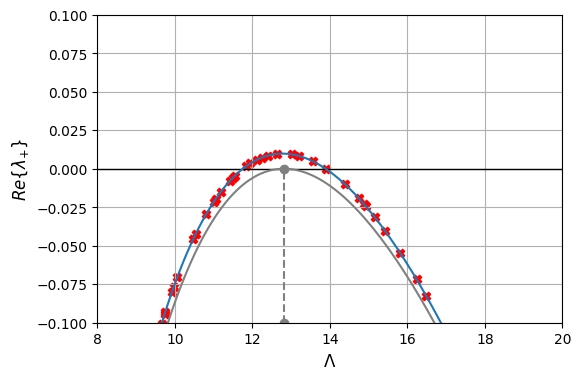

In [23]:
critical_eig = compute_critical_eigenvalue()
print(critical_eig, compute_critical_sigma())
## Initial State ##
u_eq = np.full(num_nodes, compute_fixed_point()[0], dtype= float)
v_eq = np.full(num_nodes, compute_fixed_point()[1],  dtype= float)
u_0 = perturbed_array(u_eq, perturbation_amplitude= 0.05)
v_0 = v_eq
y_0 = np.concatenate((u_0, v_0))
## Graph Definition ##
g = ba_graph()
[index, eig] = find_closest_eigenvalue(g, critical_eig)
laplacian_matrix= np.array(g.laplacian())

## Dispersion Relation Plot
fig, ax = plt.subplots(figsize = (6,4))
ax.set_xlim([8, 20])
ax.set_ylim( [-0.1, +0.1])
ax.grid()
ax.axhline(y = 0, color='black', linestyle='-', linewidth=1)
x_values = np.linspace(0, 100, 1000)
y_values = [compute_upper_branch(x) for x in x_values]
z_values = [compute_upper_branch(x, sigma= compute_critical_sigma()) for x in x_values]
ax.plot(x_values, y_values)
ax.plot(x_values, z_values, color = "grey")
laplacian_matrix = np.array(g.laplacian())
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
eigen_y_values = [compute_upper_branch(x) for x in eigenvalues]
ax.scatter(eigenvalues, eigen_y_values, marker= 'X', color = 'red')
plt.plot([compute_critical_eigenvalue(), compute_critical_eigenvalue()], [-0.1, 0], marker='o', color = "grey", linestyle = "dashed")
ax.set_xlabel(r"$\Lambda$", fontsize = 12)
ax.set_ylabel(r"$Re\{\lambda_{+}\}$", fontsize = 12)
plt.savefig("figures/simulation_dispersion.pdf")

In [24]:
## Time Steps Definition ##
t_span = (0, 200)
n_steps = 400
t_eval = np.linspace(t_span[0], t_span[1], n_steps)
sol = solve_ivp(rd_model, t_span, y_0, args=(laplacian_matrix, sigma), t_eval=t_eval, method='RK45')

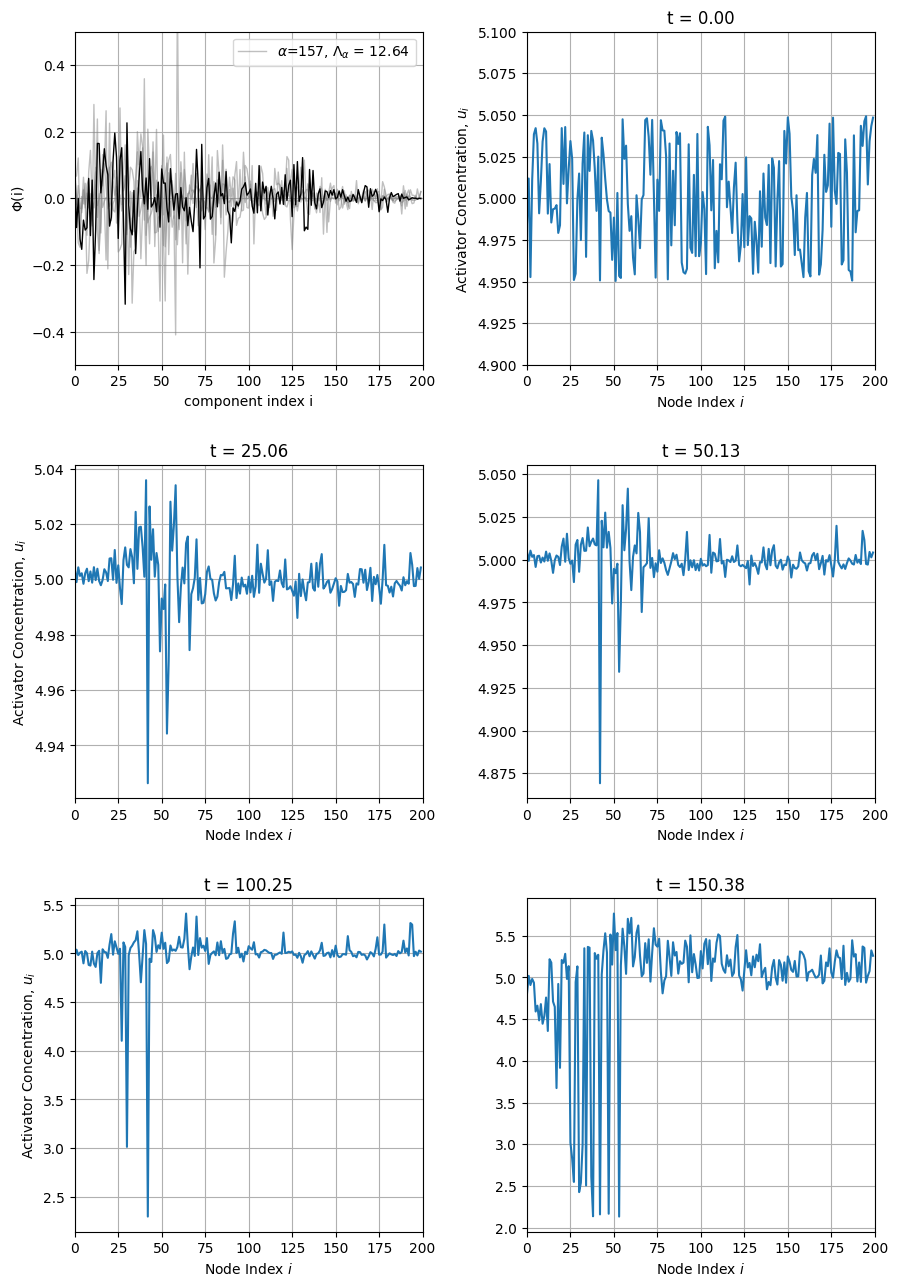

In [49]:
## Snapshot Plots ##
snapshot_idxs = [0, 50, 100, 200, 300]

fig, axs = plt.subplots(3,2, figsize = (10, 15))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)
#first row
plot_eigvec(g, index -1, axs[0, 0], color= 'grey', a = 0.5)
plot_eigvec(g, index -2, axs[0, 0], color= 'grey', a = 0.5)
plot_eigvec(g, index +1, axs[0, 0], color= 'grey', a = 0.5)
plot_eigvec(g, index +2, axs[0, 0], color= 'grey', a = 0.5)
plot_eigvec(g, index, axs[0, 0], color = "black", legend= True)

for i,idx in enumerate(snapshot_idxs):
    i = i +1
    snapshot_time = sol.t[idx]
    snapshot_y = sol.y[:, idx]
    if i < 2:
        axs[0, i].set_xlim(0, num_nodes)
        axs[0, i].set_ylim(4.90, 5.10)
        axs[0, i].plot(range(num_nodes), snapshot_y[:num_nodes], label='Activator density')
        if i == 1:
            axs[0, i].set_ylabel(f'Activator Concentration, $u_i$')
        else:
            axs[0, i].set_ylabel('')
        axs[0, i].set_xlabel(f'Node Index $i$')
        axs[0, i].set_title(f't = {snapshot_time:.2f}')
        axs[0, i].grid()
    elif i< 4:
        i = i - 2
        axs[1, i].set_xlim(0, num_nodes)
        axs[1, i].plot(range(num_nodes), snapshot_y[:num_nodes])
        if i == 0:
            axs[1, i].set_ylabel(f'Activator Concentration, $u_i$')
        else:
            axs[1, i].set_ylabel('')
        axs[1, i].set_xlabel(f'Node Index $i$')
        axs[1, i].set_title(f't = {snapshot_time:.2f}')
        axs[1, i].grid()
    else:
        i = i - 4
        axs[2, i].set_xlim(0, num_nodes)
        axs[2, i].plot(range(num_nodes), snapshot_y[:num_nodes])
        if i == 0:
            axs[2, i].set_ylabel(f'Activator Concentration, $u_i$')
        else:
            axs[1, i].set_ylabel('')
        axs[2, i].set_xlabel(f'Node Index $i$')
        axs[2, i].set_title(f't = {snapshot_time:.2f}')
        axs[2, i].grid()
plt.savefig("figures/snapshots.pdf")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


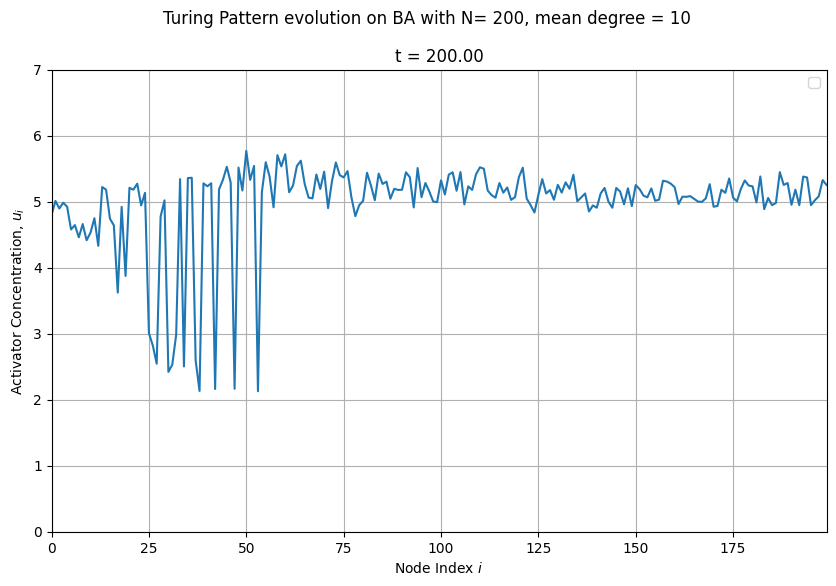

In [26]:
import matplotlib.animation as animation
import imageio_ffmpeg

fig, ax = plt.subplots(figsize=(10, 6))
line1, = ax.plot([], [])
ax.set_xlim(0, num_nodes-1)
ax.set_ylim(0, 7) 
ax.set_xlabel(f'Node Index $i$')
ax.set_ylabel(f'Activator Concentration, $u_i$')
plt.suptitle(f"Turing Pattern evolution on BA with N= {num_nodes}, mean degree = {mean_degree}")
ax.legend()
ax.grid(True)

# Initialization function for the animation
def init():
    line1.set_data([], [])
    return (line1,)

# Animation update function
def update(frame):
    line1.set_data(range(num_nodes), sol.y[:num_nodes, frame])
    ax.set_title(f't = {sol.t[frame]:.2f}')
    return (line1,)

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(sol.t), init_func=init, blit=True)

#ani.save('prova.gif', writer=PillowWriter(fps=30))
#ani.save('prova.mp4', writer= 'ffmpeg', fps = 30)
ani.save('below_critical.mp4', writer= 'ffmpeg', fps = 30)

plt.show()

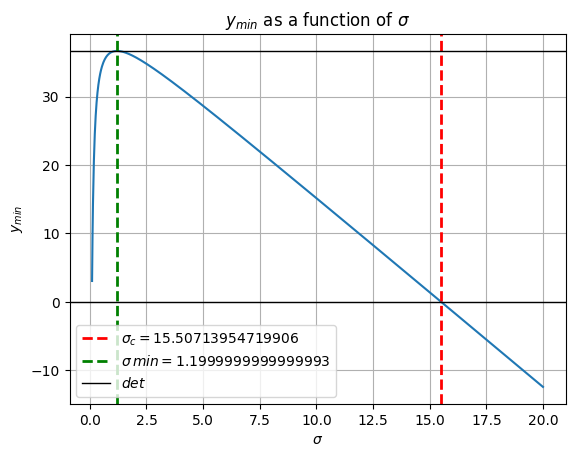

In [ ]:
def y_min(x):
    J = compute_jacobian()
    det = np.linalg.det(J)
    y = det - np.square( J[1,1] + x * J[0,0]) / (4 * x) 
    return y

sigma_values = np.linspace(0.1, 20, 1000)
y = [y_min(s) for s in sigma_values]

fig, ax = plt.subplots()
ax.plot(sigma_values, y)
ax.grid()
ax.set_title(r"$y_{min}$ as a function of $\sigma$")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$y_{min}$")
sigma_critical = compute_critical_sigma()
ax.axvline(x= sigma_critical, color='r', linestyle='--', linewidth=2, label= rf"$\sigma_c = {sigma_critical}$")
J = compute_jacobian()
sigma_min = np.abs(J[1,1]) / J[0,0]
ax.axvline(x= sigma_min, color='g', linestyle='--', linewidth=2, label= rf"$\sigma\,min = {sigma_min}$")
ax.axhline(y = 0, color='black', linestyle='-', linewidth=1)
ax.axhline(y = np.linalg.det(J), color='black', linestyle='-', linewidth=1, label= rf"$det$")
ax.legend()

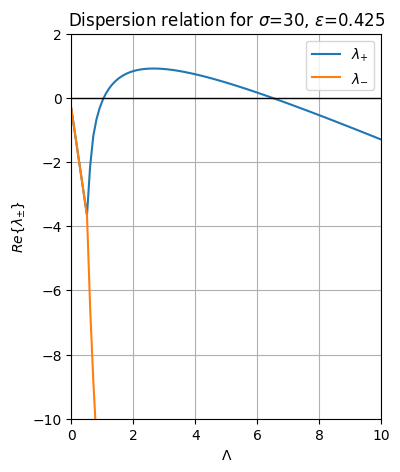

In [44]:
trial_epsilon = 0.425
trial_sigma = 30
x_values = np.linspace(0, 10, 100)
y_values = [compute_upper_branch(x, sigma = trial_sigma, epsilon= trial_epsilon) for x in x_values]
z_values = [compute_lower_branch(x, sigma = trial_sigma, epsilon= trial_epsilon) for x in x_values]

fig, ax = plt.subplots(figsize = (4,5))
ax.plot(x_values, y_values, label = r"$\lambda_{+}$")
ax.plot(x_values, z_values, label = r"$\lambda_{-}$")
ax.set_xlim([0, 10])
ax.set_ylim( [-10, 2])
ax.grid()
ax.axhline(y = 0, color='black', linestyle='-', linewidth=1)
ax.legend()
ax.set_title(rf"Dispersion relation for $\sigma$={trial_sigma}, $\epsilon$={trial_epsilon}")
ax.set_xlabel(r"$\Lambda$")
ax.set_ylabel(r"$Re\{\lambda_{\pm}\}$")
plt.savefig("figures/single_dispersion.pdf")

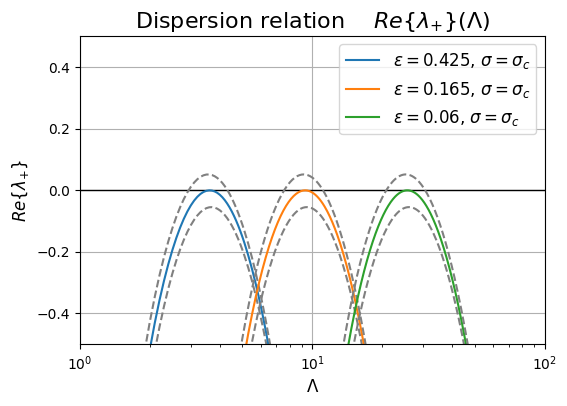

In [61]:
trial_epsilons = [0.425, 0.165, 0.060]
trial_sigmas = [15, 15.5, 16]


fig, ax = plt.subplots(figsize = (6,4))
ax.set_xlim([1, 100])
ax.set_xscale('log')
ax.set_ylim( [-0.5, +0.5])
ax.grid()
ax.axhline(y = 0, color='black', linestyle='-', linewidth=1)

for trial_epsilon in trial_epsilons:
    for trial_sigma in trial_sigmas:
        x_values = np.linspace(0, 100, 1000)
        y_values = [compute_upper_branch(x, sigma = trial_sigma, epsilon= trial_epsilon) for x in x_values]
        z_values = [compute_lower_branch(x, sigma = trial_sigma, epsilon= trial_epsilon) for x in x_values]
        if trial_sigma == trial_sigmas[1]:   
            ax.plot(x_values, y_values, label = fr"$\epsilon= {trial_epsilon}$, $\sigma = \sigma_c$")
        else:
            ax.plot(x_values, y_values, linestyle = 'dashed', color = 'gray')
ax.legend(fontsize = 12)
ax.set_title(r"Dispersion relation $\quad Re\{\lambda_{+}\}(\Lambda)$", fontsize = 16)
ax.set_xlabel(r"$\Lambda$", fontsize = 12)
ax.set_ylabel(r"$Re\{\lambda_{+}\}$", fontsize = 12)
plt.savefig("figures/multiple_dispersion.pdf")